# FLux.jl MNIST example

Training a Convolutional Neural Network (CNN) against the famous MNIST dataset of handwritten digits. Much of the credit for this notebook should go to this [blog](https://www.freecodecamp.org/news/deep-learning-with-julia/) and its code published on [github](https://github.com/AndreyGermanov/phones_reader).

In [1]:
# Packages
using Pkg
Pkg.activate(".")
#Pkg.instantiate()
using Images
using Flux
using ZipFile
using BSON
using Plots, Measures
using JLD

# optional gpu usage
const use_gpu = true
if use_gpu
    using CUDA
end

  Activating project at `~/src_nobackup/julia_ml_tests.jl.git`


In [2]:
# mnist images from [this archive](https://www.kaggle.com/datasets/jidhumohan/mnist-png)
# we have a copy in the data directory
data_root = "data"
zip_file = "archive.zip"

function mkdir_p(path) # make directory and parents if needed
    if !isdir(path)
        # check for parent directory
        if !(path=="/" || path=="")
            parentDir = dirname(path)
            if !isdir(parentDir)
                mkdir_p(parentDir)
            end
        end
        mkdir(path)
    end
end

if !isdir(joinpath(data_root,"mnist_png"))
    zarchive = ZipFile.Reader(joinpath(data_root,zip_file))
    for f in zarchive.files
        if contains(f.name,"mnist_png/mnist_png") # the has two copies of the data
            continue
        end
        println(f.name)
        fullFilePath = joinpath(data_root,f.name)
        if endswith(f.name,"/")
            println("creating directory: ",fullFilePath)
            mkdir_p(fullFilePath)
        else
            println("creating file: ",fullFilePath)
            # check for parent directory
            parentDir = dirname(fullFilePath)
            if !isdir(parentDir)
                println("creating directory: ",parentDir)
                mkdir_p(parentDir)
            end
            out =  open(fullFilePath,"w")
            write(out,read(f,String))
            close(out) 
        end
    end
    close(zarchive)
end

# paths with images and labels
training_images_path = joinpath(data_root,"mnist_png","training")
testing_images_path = joinpath(data_root,"mnist_png","testing")

nothing

In [3]:

# Function that loads images from files and returns a dataset
function createDataset(path,number_of_images)
    X = zeros(Float32,28,28,1,number_of_images) # 28x28x1 is the size of the images, one channel
    y = zeros(Float32,number_of_images)
    icount = 0
    for label in readdir(path)
        println("Loading label $(label) from path $(path)")
        for file in readdir(joinpath(path,label))
            icount += 1
            if icount%1000 == 0
                println("$(icount): Loading file $(file) from path $(path)/$(label)")
            end
            img = load(joinpath(path,label,file))
            data = reshape(Float32.(channelview(img)),28,28,1)
            X[:,:,1,icount] = data
            y[icount]= parse(Float32,label)
        end
    end
    return X,y
end;

# Load the dataset
if !isfile("data/mnist.jld")
    x_train,y_train = createDataset(training_images_path,60000);
    x_test,y_test = createDataset(testing_images_path,10000);
    @save "data/mnist.jld" x_train y_train x_test y_test
else
    @load "data/mnist.jld" x_train y_train x_test y_test
end

y_train_onehot = Flux.onehotbatch(y_train, 0:9)
y_test_onehot = Flux.onehotbatch(y_test, 0:9);  

In [4]:
# Limit the size of the training set
# Note that training set is not shuffled. It has eg all the zeros at the start
n_train = 2000
idx = rand(1:size(x_train,4),n_train)
x_train = x_train[:,:,:,idx]
y_train = y_train[idx]
y_train_onehot = Flux.onehotbatch(y_train, 0:9)

nothing

In [5]:
# move data to gpu
if use_gpu
    x_train_gpu = gpu(x_train)
    y_train_onehot_gpu = gpu(y_train_onehot)
    y_train_gpu = gpu(y_train)
    x_test_gpu = gpu(x_test)
    y_test_onehot_gpu = gpu(y_test_onehot)
    y_test_gpu = gpu(y_test)
else
    x_train_gpu = x_train
    y_train_onehot_gpu = y_train_onehot
    y_train_gpu = y_train
    x_test_gpu = x_test
    y_test_onehot_gpu = y_test_onehot
    y_test_gpu = y_test
end

nothing

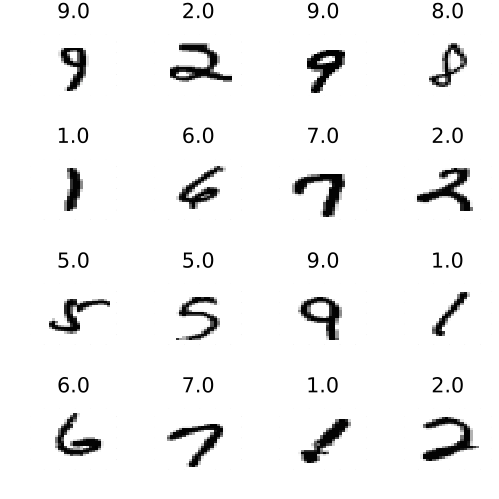

In [6]:
size(x_train),size(y_train),size(x_test),size(y_test)
n_train,n_test = size(x_train)[end],size(x_test)[end]
# show a few images
#heatmap(1f0.-x_train[:,:,1,1],size=(100,100),legend=false,showaxis=false,color=:greys,margin=0mm,title="$(y_train[1])")
plot_array = []
for i = 1:4, j = 1:4
    i_rand = rand(1:n_train)
    h=heatmap(1f0.-reverse(x_train[:,:,1,i_rand],dims=1),size=(100,100),legend=false,showaxis=false,color=:greys,margin=0mm,title="$(y_train[i_rand])")
    push!(plot_array, h)
end
plot(plot_array..., layout = (4,4), size = (500, 500))

In [7]:

# Define the Lenet v5 model -> http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf
model = Chain(
    Conv((5,5),1 => 6, relu),
    MaxPool((2,2)),
    Conv((5,5),6 => 16, relu),
    MaxPool((2,2)),
    Flux.flatten,
    Dense(256=>120,relu),
    Dense(120=>84, relu),
    Dense(84=>10, sigmoid),
    softmax
) 

if use_gpu
    model_gpu = gpu(model)
else
    model_gpu = model
end

nothing
     


In [8]:
# Loss and accuracy

# Define the loss function that uses the cross-entropy to 
# measure the error by comparing model predictions of data 
# row "x" with true data from labels vector "y" in one hot encoding
function loss(model, x, y_onehot)
	return Flux.crossentropy(model(x),y_onehot)
end

# Function that measures the accuracy of
# model on testing dataset
function accuracy(model,x,y)
	mx=model(x)
	n=length(y)
	return count((Flux.onecold(mx).-1) .== y)/n
end;

In [9]:
#model = model_gpu |>cpu
#a1_cpu=accuracy(model,x_train[:,:,:,1:10],y_train[1:10])
#mx=model(x_train[:,:,:,1:10])
#mx_1c=Flux.onecold(mx)


In [10]:
# some tesing only
# @time a1_gpu=accuracy(model_gpu,x_train_gpu,y_train_gpu)
# @time a1_cpu=accuracy(model,x_train,y_train)
# println("Accuracy on GPU: ",a1_gpu)
# println("Accuracy on CPU: ",a1_cpu)
# @time l1_gpu=loss(model_gpu,x_train_gpu,y_train_onehot_gpu)
# @time l1_cpu=loss(model,x_train,y_train_onehot)
# println("Loss on GPU: ",l1_gpu)
# println("Loss on CPU: ",l1_cpu)

In [11]:
# setup data loader for training data
# Assemble the training data
if use_gpu
	train_data = Flux.DataLoader((x_train_gpu,y_train_onehot_gpu), shuffle=true, batchsize=64)
else
	train_data = Flux.DataLoader((x_train,y_train_onehot), shuffle=true, batchsize=64)
end
train_data

32-element DataLoader(::Tuple{CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, OneHotArrays.OneHotMatrix{UInt32, CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}}}, shuffle=true, batchsize=64)
  with first element:
  (28×28×1×64 CuArray{Float32, 4, CUDA.Mem.DeviceBuffer}, 10×64 OneHotMatrix(::CuArray{UInt32, 1, CUDA.Mem.DeviceBuffer}) with eltype Bool,)

In [12]:

# Initialize the ADAM optimizer with default settings
optimizer = Flux.setup(Adam(),model_gpu)

# Train the model
# and display the accuracy on each
# iteration
for epoch in 1:5
	Flux.train!(loss, model_gpu, train_data, optimizer)
    println("epoch: $(epoch)") #NOTE: we careless with compute, rerunning model each time below
    println("   Accuracy for training: $(accuracy(model_gpu,x_train_gpu,y_train_gpu))")
    println("   Accuracy for testing : $(accuracy(model_gpu,x_test_gpu,y_test_gpu))")
    println("   Loss for training    : $(loss(model_gpu,x_train_gpu,y_train_onehot_gpu))")
    println("   Loss for testing     : $(loss(model_gpu,x_test_gpu,y_test_onehot_gpu))")

end
     


epoch: 1


   Accuracy for training: 0.731


   Accuracy for testing : 0.735


   Loss for training    : 1.9271423
   Loss for testing     : 1.9248906
epoch: 2
   Accuracy for training: 0.7965
   Accuracy for testing : 0.8009
   Loss for training    : 1.6718405


   Loss for testing     : 1.669309
epoch: 3
   Accuracy for training: 0.847
   Accuracy for testing : 0.8366
   Loss for training    : 1.6163288
   Loss for testing     : 1.6166949


epoch: 4


   Accuracy for training: 0.888
   Accuracy for testing : 0.8821
   Loss for training    : 1.5865014
   Loss for testing     : 1.5919523
epoch: 5
   Accuracy for training: 0.915


   Accuracy for testing : 0.9014
   Loss for training    : 1.5627532
   Loss for testing     : 1.5727644
